In [28]:
# import library
import pandas as pd
import re
import sqlite3 as sq
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset
df = pd.read_csv('DATA/train_preprocess.tsv.txt', sep='\t', names=['Tweet','Label'])
df.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [3]:
# sortir label tweet
sorted(df['Label'].unique())

['negative', 'neutral', 'positive']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   11000 non-null  object
 1   Label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [5]:
df.shape

(11000, 2)

In [6]:
# mengecek missing values
df.isna().sum()

Tweet    0
Label    0
dtype: int64

In [7]:
# mengecek data duplikat
df.duplicated().sum()

67

In [8]:
# menghapus data yang duplikat
df = df.drop_duplicates()

In [9]:
# mengecek kembali data duplikat
df.duplicated().sum()

0

In [10]:
df.shape

(10933, 2)

In [11]:
# menghitung value dari label
df.Label.value_counts()

Label
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

<Axes: ylabel='Label'>

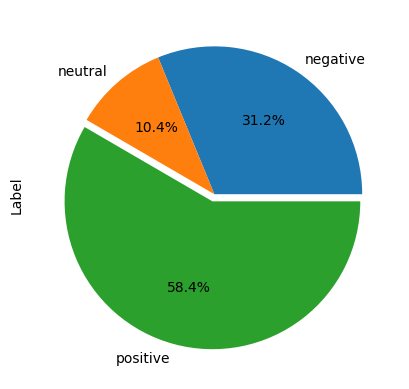

In [24]:
# data visualisasi
explode = [0, 0, 0.05]
presentase_sentiment = df.groupby("Label").Label.count()
presentase_sentiment.plot(kind = 'pie', autopct = '%1.1f%%', explode = explode)

In [25]:
# membuat kolom baru total word
df['Total Word'] = df['Tweet'].apply(lambda word: len(word.split()))
df.head()

,Tweet,Label,Total Word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17
2,lokasi strategis di jalan sumatera bandung . t...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38


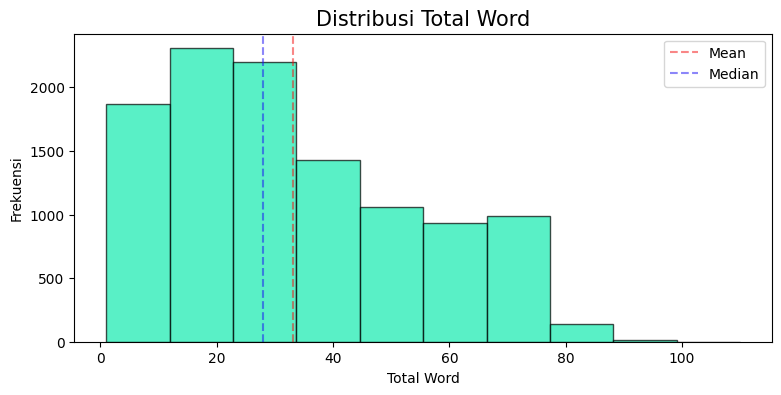

In [58]:
# data visualisasi
# palet warna
color = '#13ebaf'

# histogram
fig = plt.figure(figsize=(9, 4))
plt.hist(df['Total Word'], color=color, edgecolor='black', alpha=0.7)

# garis vertikal mean dan median
plt.axvline(x=df['Total Word'].mean(), ls='--', color='#f50f0f', alpha=0.5, label='Mean')
plt.axvline(x=df['Total Word'].median(), ls='--', color='#1a0ff5', alpha=0.5, label='Median')

# judul dan label
plt.title('Distribusi Total Word', size=15)
plt.xlabel('Total Word')
plt.ylabel('Frekuensi')

# tampilkan legend
plt.legend()

# tampilkan histogram
plt.show()

In [59]:
df['Total Word'].mean()

33.060550626543495

In [60]:
df["Total Word"].median()

28.0

In [61]:
# menghapus kolom total word
df = df.drop('Total Word', axis=1)

In [62]:
# mengubah ke huruf kecil
def lowercase(text):
    return text.lower()

In [64]:
# remove punctuation
def remove_punctuation(text):
    text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+', '', text) #menghapus https dan http
    text = re.sub('<.*?>', ' ', text) #mengganti karakter html dengan tanda petik
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) #menghilangkan semua karakter yang bukan huruf atau angka dan menggantinya dengan spasi.
    text = re.sub('\n',' ',text) #mengganti line baru dengan spasi
    text = re.sub(r':', ' ', text) #menggantikan karakter : dengan spasi 
    text = re.sub('gue','saya', text) # Mengganti kata "gue" dengan kata "saya"
    text = re.sub(r'\b[a-zA-Z]\b', ' ', text) #menghapus single char
    text = ' '.join(text.split()) #memisahkan dan menggabungkan kata
    text = text.strip() #menghilangkan whitespace di awal dan di akhir teks
    text = re.sub(r'pic.twitter.com.[\w]+', '', text) #menghapus link picture
    text = re.sub(r'\buser\b',' ', text) #menghapus kata 'user'
    text = re.sub(r'\brt\b',' ', text) #menghapus awalan rt
    text = re.sub('RT',' ', text) #menghapus RT simbol
    text = re.sub(r'‚Ä¶', '', text)
    return text

In [65]:
# membuat database
conn = sq.connect('database_pl.db')

In [66]:
# import kamusalay
df_kamusalay = pd.read_csv('DATA/new_kamusalay.csv', encoding='latin-1', names=['alay','normal'])

In [68]:
df_kamusalay.to_sql('kamusalay', conn, if_exists='replace', index=False)
df_kamusalay = pd.DataFrame(df_kamusalay)
df_kamusalay

,alay,normal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [69]:
db = sq.connect('database_pl.db', check_same_thread= False)
q_kamusalay = 'SELECT * FROM kamusalay'
t_kamusalay = pd.read_sql_query(q_kamusalay, db)

In [70]:
alay_dict = dict(zip(t_kamusalay['alay'], t_kamusalay['normal']))
def alay_to_normal(s):
    for word in alay_dict:
        return ' '.join([alay_dict[word] if word in alay_dict else word for word in s.split(' ')])